# Baseline

In [36]:
from tqdm import *
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor
from catboost import Pool

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, explained_variance_score
from xgboost import XGBClassifier, XGBRegressor
from vecstack import stacking

In [37]:
houston = pd.read_csv('D:\\SF\\Final\\houston_coord_pop_adrcoord.csv')
houston.shape

(14593, 39)

In [38]:
# функция считает растояние и азимут между двумя точками
# код взят здесь https://pastebin.com/PHeWmiEN
import math
def dist_azimut(llat1, llong1, llat2, llong2):
    #pi - число pi, rad - радиус сферы (Земли)
    rad = 6372795
    #координаты двух точек
    # координаты центра
    #llat1 = row['city_latitude']
    #llong1 = row['city_longitude']
    # координаты места
    #llat2 = row['zip_latitude']
    #llong2 = row['zip_longitude']
    #в радианах
    lat1 = llat1*math.pi/180.
    lat2 = llat2*math.pi/180.
    long1 = llong1*math.pi/180.
    long2 = llong2*math.pi/180.
    #косинусы и синусы широт и разницы долгот
    cl1 = math.cos(lat1)
    cl2 = math.cos(lat2)
    sl1 = math.sin(lat1)
    sl2 = math.sin(lat2)
    delta = long2 - long1
    cdelta = math.cos(delta)
    sdelta = math.sin(delta)
    #вычисления длины большого круга
    y = math.sqrt(math.pow(cl2*sdelta,2)+math.pow(cl1*sl2-sl1*cl2*cdelta,2))
    x = sl1*sl2+cl1*cl2*cdelta
    ad = math.atan2(y,x)
    dist = round(ad*rad) # в метрах
    #вычисление начального азимута
    x = (cl1*sl2) - (sl1*cl2*cdelta)
    y = sdelta*cl2
    z = math.degrees(math.atan(-y/x))
    if (x < 0):
        z = z+180.
    z2 = (z+180.) % 360. - 180.
    z2 = - math.radians(z2)
    anglerad2 = z2 - ((2*math.pi)*math.floor((z2/(2*math.pi)))) # в радианах
    angledeg = round((anglerad2*180.)/math.pi, 2) # в градусах   
    #row['distance'] = dist
    #row['azimut'] = angledeg    
    return dist, angledeg

In [39]:
# оставляем топ значений остальные other
heating_top = houston['Heating'].value_counts()
heating_top = heating_top[heating_top.values>10]
houston['Heating'] = houston['Heating'].apply(lambda x: x if x in heating_top else 'other')

In [40]:
# оставляем топ значений остальные other
cooling_top = houston['Cooling'].value_counts()
cooling_top = cooling_top[cooling_top.values>10]
houston['Cooling'] = houston['Cooling'].apply(lambda x: x if x in cooling_top else 'other')

In [41]:
def distanceToCentre(row):
    if (row['adress_latitude']!='Location error') and (row['adress_longitude']!='Location error'):
        dist, az = dist_azimut(float(row['city_latitude']), 
                               float(row['city_longitude']), 
                               float(row['adress_latitude']), 
                               float(row['adress_longitude']))
        row['distanceToCentre'] = dist
        row['azimuth'] = az
    else:
        row['distanceToCentre'] = -1
        row['azimuth'] = -1
    return row

In [42]:
def distanceToPost(row):
    if (row['adress_latitude']!='Location error') and (row['adress_longitude']!='Location error'):
        dist, az = dist_azimut(float(row['adress_latitude']), 
                               float(row['adress_longitude']), 
                               float(row['zip_latitude']), 
                               float(row['zip_longitude']))
        row['distanceToPost'] = dist
    else:
        row['distanceToPost'] = -1
    return row

In [43]:
def distCentePost(row):
    dist, az = dist_azimut(float(row['city_latitude']), 
                           float(row['city_longitude']), 
                           float(row['zip_latitude']), 
                           float(row['zip_longitude']))
    row['centreToPost'] = dist
    row['postAzimuth'] = az
    return row

In [44]:
# не используем, т.к снижает качество модели
# получаем расстояние до центра и азимут объекта
#tqdm.pandas(tqdm_notebook)
#houston = houston.progress_apply(lambda row: distanceToCentre(row), axis=1)

In [45]:
# не используем, т.к снижает качество модели
# получаем растояние до почты
#tqdm.pandas(tqdm_notebook)
#houston = houston.progress_apply(lambda row: distanceToPost(row), axis=1)

In [46]:
# получаем растояние от почты до центра
tqdm.pandas(tqdm_notebook)
houston = houston.progress_apply(lambda row: distCentePost(row), axis=1)

In [47]:
# заполняем пропуски и и округляем
#centreMed = houston[houston['distanceToCentre']!=-1]['distanceToCentre'].median()
#postMed = houston[houston['distanceToPost']!=-1]['distanceToPost'].median()
#azMean = houston[houston['azimuth']!=-1]['azimuth'].mean()

#houston['distanceToCentre'] = houston['distanceToCentre'].apply(lambda x: centreMed if x==-1 else x)
#houston['distanceToPost'] = houston['distanceToPost'].apply(lambda x: postMed if x==-1 else x)
#houston['azimuth'] = houston['azimuth'].apply(lambda x: azMean if x==-1 else x)

#houston['distanceToPost'] = houston['distanceToPost'].round()
#houston['distanceToCentre'] = houston['distanceToCentre'].round()
#houston['azimuth'] = houston['azimuth'].round(0)
houston['postAzimuth'] = houston['postAzimuth'].round(0)

In [48]:
dataset = houston.copy()

In [49]:
dataset.columns

Index(['status', 'propertyType', 'street', 'baths', 'city', 'sqft', 'zipcode',
       'beds', 'state', 'stories', 'target', 'private_pool', 'mls_Id',
       'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft', 'baths_count',
       'fireplace_yes_no', 'year_built', 'remodeled_year', 'school_count',
       'school_rating_mean', 'school_distance_mean', 'preschool',
       'kindergarten', 'elementary_school', 'middle_school', 'high_school',
       'private_school', 'zip_latitude', 'zip_longitude', 'city_latitude',
       'city_longitude', 'Female', 'Male', 'adress_latitude',
       'adress_longitude', 'centreToPost', 'postAzimuth'],
      dtype='object')

In [50]:
dataset.drop(['street', 'baths', 'city', 'state', 'zipcode', 'mls_Id', 'zip_latitude', 'zip_longitude', 'city_latitude',
       'city_longitude', 'adress_latitude', 'adress_longitude'], axis=1, inplace=True)

In [51]:
# удаляем признаки которые не нужны
#dataset.drop(['street', 'baths', 'city', 'state', 'zipcode', 'mls_Id', 'zip_latitude', 'zip_longitude', 'city_latitude',
#       'city_longitude', 'adress_latitude', 'adress_longitude', 'distanceToCentre', 'azimuth', 'distanceToPost'],
#             axis=1, inplace=True)

In [52]:
# переведем значения в цифру для признака private_pool
# yes - 1
# no - 0
dataset['private_pool'] = dataset['private_pool'].apply(lambda x: 1 if x=='yes' else 0)

In [53]:
#dataset = dataset[dataset['distanceToCentre']!=-999]
dataset.shape

(14593, 29)

# Ищем выбросы

In [54]:
def IQR(df, col):
    median = df[col].median()
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
          , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    df[col].loc[df[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 30, label = 'IQR')
    plt.legend();

count     14593.000000
mean       2117.848626
std        3051.252154
min        -999.000000
25%        1332.000000
50%        2018.000000
75%        2751.000000
max      262231.000000
Name: sqft, dtype: float64

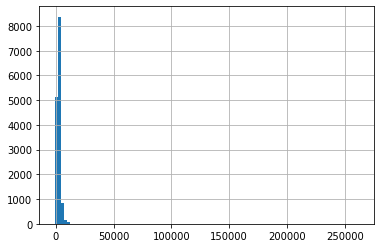

In [55]:
dataset['sqft'].hist(bins=100)
dataset['sqft'].describe()

25-й перцентиль: 1332.0, 75-й перцентиль: 2751.0, IQR: 1419.0,  Границы выбросов: [-796.5, 4879.5].


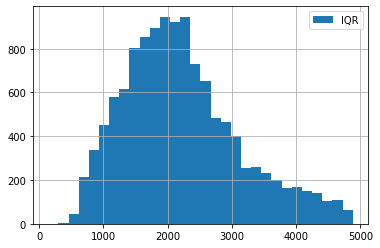

In [56]:
IQR(dataset, 'sqft')

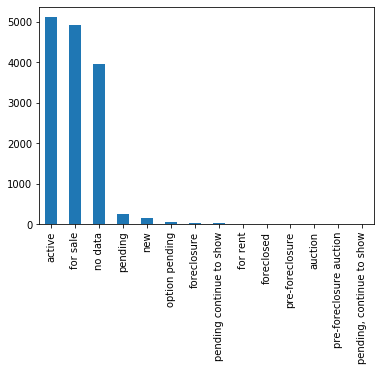

In [57]:
dataset['status'].value_counts().plot.bar()

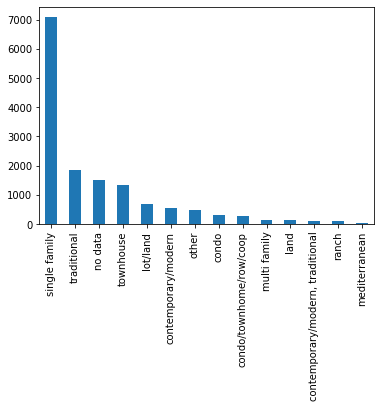

In [58]:
dataset['propertyType'].value_counts().plot.bar()

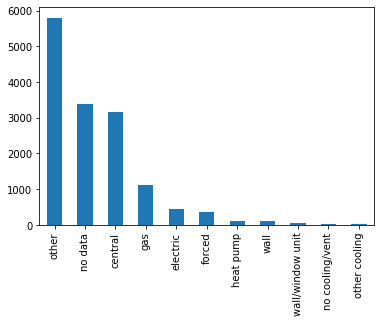

In [59]:
dataset['Heating'].value_counts().plot.bar()

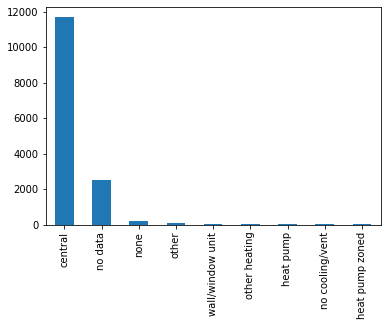

In [60]:
dataset['Cooling'].value_counts().plot.bar()

count    14593.000000
mean         1.473378
std          1.045363
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         22.000000
Name: stories, dtype: float64

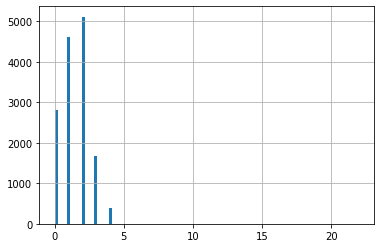

In [61]:
dataset['stories'].hist(bins=100)
dataset['stories'].describe()

25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


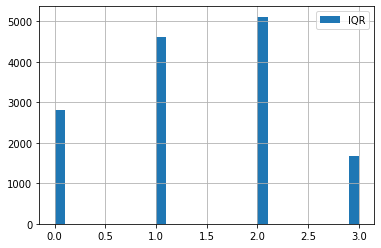

In [62]:
IQR(dataset, 'stories')

count    14593.000000
mean         1.734736
std          2.191587
min         -1.000000
25%         -1.000000
50%          3.000000
75%          3.000000
max         18.000000
Name: beds, dtype: float64

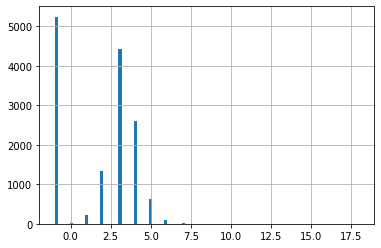

In [63]:
dataset['beds'].hist(bins=100)
dataset['beds'].describe()

25-й перцентиль: -1.0, 75-й перцентиль: 3.0, IQR: 4.0,  Границы выбросов: [-7.0, 9.0].


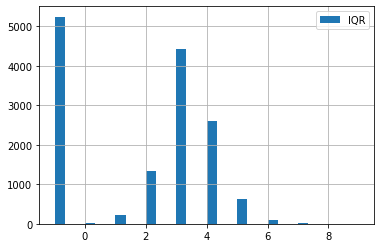

In [64]:
IQR(dataset, 'beds')

count    1.459300e+04
mean     5.102768e+05
std      8.567327e+05
min      8.000000e+02
25%      1.870000e+05
50%      2.999000e+05
75%      4.990000e+05
max      2.950000e+07
Name: target, dtype: float64

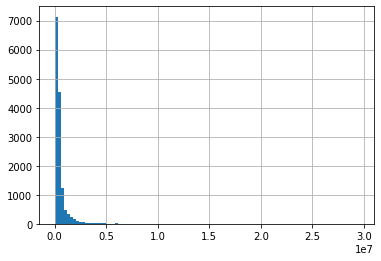

In [65]:
dataset['target'].hist(bins=100)
dataset['target'].describe()

25-й перцентиль: 187000.0, 75-й перцентиль: 499000.0, IQR: 312000.0,  Границы выбросов: [-281000.0, 967000.0].


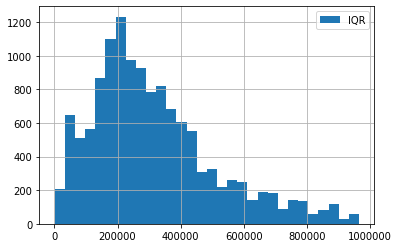

In [66]:
IQR(dataset, 'target')

count    1.459300e+04
mean     1.941077e+04
std      1.109833e+05
min      0.000000e+00
25%      1.890000e+03
50%      6.098000e+03
75%      9.375000e+03
max      1.010592e+07
Name: lotsize, dtype: float64

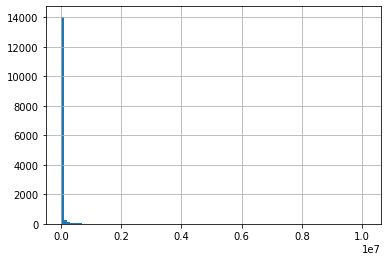

In [67]:
dataset['lotsize'].hist(bins=100)
dataset['lotsize'].describe()

25-й перцентиль: 1890.0, 75-й перцентиль: 9375.0, IQR: 7485.0,  Границы выбросов: [-9337.5, 20602.5].


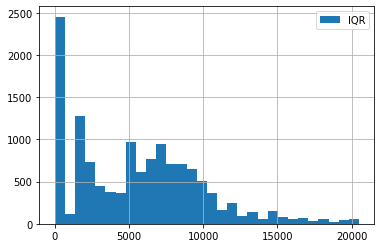

In [68]:
IQR(dataset, 'lotsize')

count    14593.000000
mean        34.206058
std        419.609775
min       -999.000000
25%         91.000000
50%        140.000000
75%        204.000000
max       3636.000000
Name: Price/sqft, dtype: float64

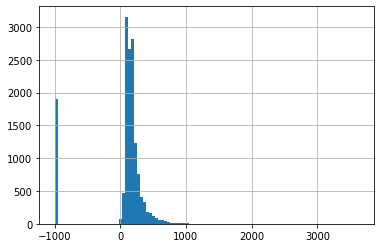

In [69]:
dataset['Price/sqft'].hist(bins=100)
dataset['Price/sqft'].describe()

25-й перцентиль: 91.0, 75-й перцентиль: 204.0, IQR: 113.0,  Границы выбросов: [-78.5, 373.5].


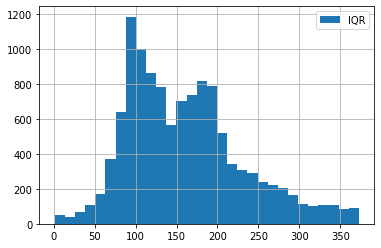

In [70]:
IQR(dataset, 'Price/sqft')

count    14593.000000
mean         1.679709
std          2.139639
min         -1.000000
25%         -1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: baths_count, dtype: float64

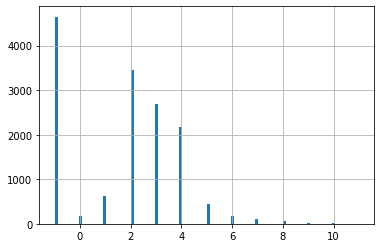

In [71]:
dataset['baths_count'].hist(bins=100)
dataset['baths_count'].describe()

25-й перцентиль: -1.0, 75-й перцентиль: 3.0, IQR: 4.0,  Границы выбросов: [-7.0, 9.0].


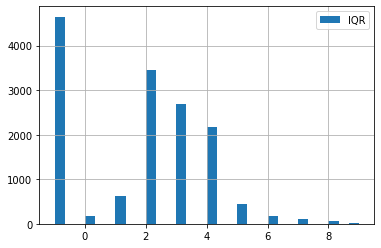

In [72]:
IQR(dataset, 'baths_count')

count    14593.000000
mean      1703.523744
std        695.229105
min          0.000000
25%       1953.000000
50%       1980.000000
75%       2010.000000
max       2022.000000
Name: year_built, dtype: float64

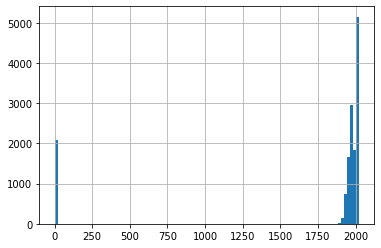

In [73]:
dataset['year_built'].hist(bins=100)
dataset['year_built'].describe()

25-й перцентиль: 1953.0, 75-й перцентиль: 2010.0, IQR: 57.0,  Границы выбросов: [1867.5, 2095.5].


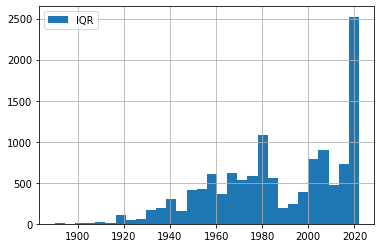

In [74]:
IQR(dataset, 'year_built')

count    14593.000000
mean      1702.170972
std        694.682077
min          0.000000
25%       1950.000000
50%       1979.000000
75%       2007.000000
max       2022.000000
Name: remodeled_year, dtype: float64

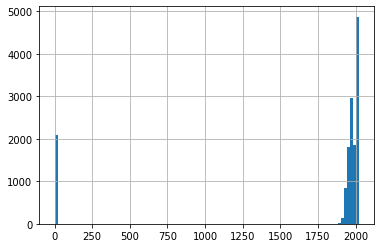

In [75]:
dataset['remodeled_year'].hist(bins=100)
dataset['remodeled_year'].describe()

25-й перцентиль: 1950.0, 75-й перцентиль: 2007.0, IQR: 57.0,  Границы выбросов: [1864.5, 2092.5].


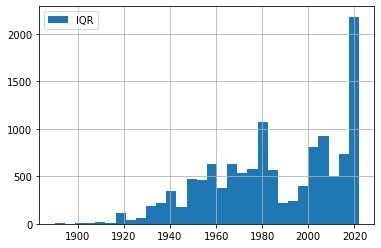

In [76]:
IQR(dataset, 'remodeled_year')

count    14593.000000
mean     14786.567395
std       8658.774231
min        538.000000
25%       7554.000000
50%      13363.000000
75%      19647.000000
max      41034.000000
Name: centreToPost, dtype: float64

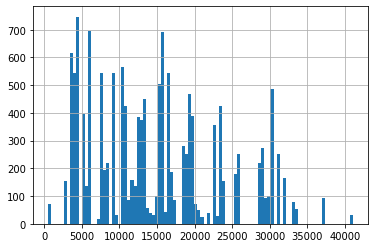

In [77]:
dataset['centreToPost'].hist(bins=100)
dataset['centreToPost'].describe()

25-й перцентиль: 7554.0, 75-й перцентиль: 19647.0, IQR: 12093.0,  Границы выбросов: [-10585.5, 37786.5].


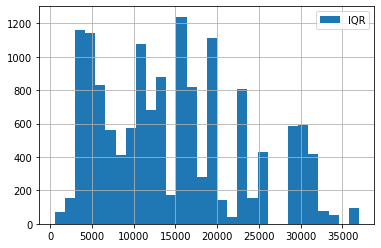

In [78]:
IQR(dataset, 'centreToPost')

In [80]:
#dataset['distanceToPost'].hist(bins=100)
#dataset['distanceToPost'].describe()

In [ ]:
#IQR(dataset, 'distanceToPost')

In [ ]:
#dataset['distanceToCentre'].hist(bins=100)
#dataset['distanceToCentre'].describe()

In [ ]:
#IQR(dataset, 'distanceToCentre')

count     14593.000000
mean      66091.220722
std       31031.709390
min         640.000000
25%       48308.000000
50%       59836.000000
75%       74464.000000
max      192760.000000
Name: Female, dtype: float64

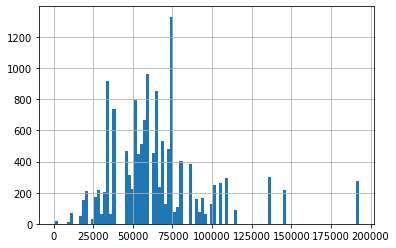

In [81]:
dataset['Female'].hist(bins=100)
dataset['Female'].describe()

count     14593.000000
mean      65707.000069
std       30365.215823
min         824.000000
25%       47452.000000
50%       61944.000000
75%       78676.000000
max      187788.000000
Name: Male, dtype: float64

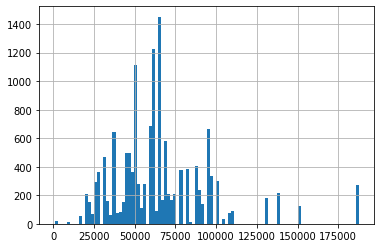

In [82]:
dataset['Male'].hist(bins=100)
dataset['Male'].describe()

# Избавляемся от выбросов

In [83]:
def clear(df, col):
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    df_clear = df.loc[df[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    return df_clear

def clear2(df):# очищаем те колонки где выбросы ярко выражены на графиках
    df_output = df.copy()
    df_output = clear(df_output, 'sqft')
    df_output = clear(df_output, 'beds')
    df_output = clear(df_output, 'baths_count')
    df_output = clear(df_output, 'year_built')
    df_output = clear(df_output, 'Price/sqft')
    #df_output = clear(df_output, 'distanceToPost')
    #df_output = clear(df_output, 'distanceToCentre')
    print(df_output.shape)
    return df_output

In [84]:
dataset = clear2(dataset)

(10801, 29)


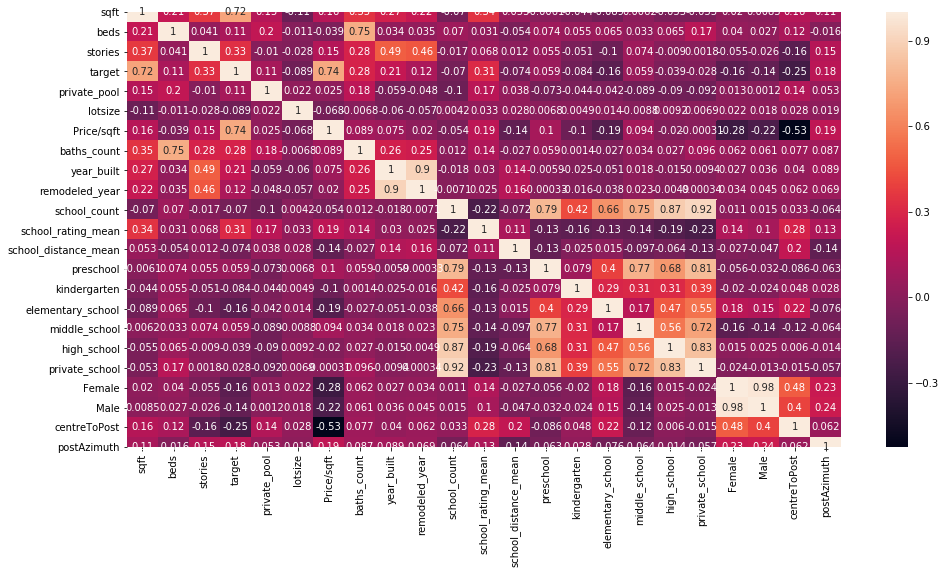

In [85]:
# полная матрица корреляций
# используем метод Pandas corr()
C = dataset.corr(method='pearson')
# представим корреляционную матрицу в виде "тепловой карты" с помощью функции heatmap из библиотеки seaborn
plt.figure(figsize=(16,8)) # размер графика
sns.heatmap(data=C, annot=True)

In [ ]:
dataset.columns

In [86]:
# удаляем все категориальные признаки, т.к не оказывают существенного влияния на качаство модели
ds = dataset.drop(['status', 'propertyType', 'fireplace_yes_no', 'Heating', 'Cooling', 'Parking', 
                   'preschool', 'kindergarten', 'elementary_school', 'middle_school', 
                   'high_school', 'private_school'],axis=1)

In [87]:
ds.columns

Index(['sqft', 'beds', 'stories', 'target', 'private_pool', 'lotsize',
       'Price/sqft', 'baths_count', 'year_built', 'remodeled_year',
       'school_count', 'school_rating_mean', 'school_distance_mean', 'Female',
       'Male', 'centreToPost', 'postAzimuth'],
      dtype='object')

In [88]:
#dummies = pd.get_dummies(dataset, columns=['status', 'propertyType', 'fireplace_yes_no', 'Heating', 'Cooling', 'Parking'])
#dummies.shape

In [89]:
dummies = ds.copy()
dummies.shape

(10801, 17)

In [90]:
# разбиваем выборку на тестовую и тренировочную
y = dummies['Price/sqft']
X = dummies.drop(['target','Price/sqft'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [92]:
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

In [93]:
# куда пишем предикты по каждой модели
predictions = pd.DataFrame(0, columns=['rfr'], index=y_test.index)

In [94]:
rfr = RandomForestRegressor(n_estimators=2000,
                            bootstrap=False,
                            criterion='mse',
                            n_jobs=-1,
                            max_features=3,
                            max_depth=55,
                            min_samples_split=5,
                            random_state=42
                           )

rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test).round(0)
predictions['rfr'] = y_predict
mape = mean_absolute_percentage_error(y_test, y_predict)
medape = median_absolute_percentage_error(y_test, y_predict)
print('MAPE:', mape)
print('MedAPE:', medape)

MAPE: 15.594232415549728
MedAPE: 8.181818181818182


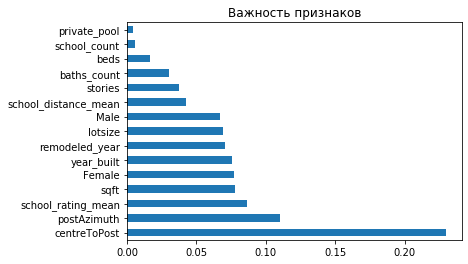

In [95]:
plt.figure()
plt.title("Важность признаков")
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(rfr.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [96]:
# ExtraTreesRegressor
etr = ExtraTreesRegressor(n_estimators=200, 
                            criterion='mse',
                            n_jobs=4,
                            random_state=42
                              )

etr.fit(X_train, y_train)
y_predict = etr.predict(X_test).round(0)
predictions['etr'] = y_predict
mape = mean_absolute_percentage_error(y_test, y_predict)
medape = median_absolute_percentage_error(y_test, y_predict)
print('MAPE:', mape)
print('MedAPE:', medape)

MAPE: 15.02224540806033
MedAPE: 7.8125


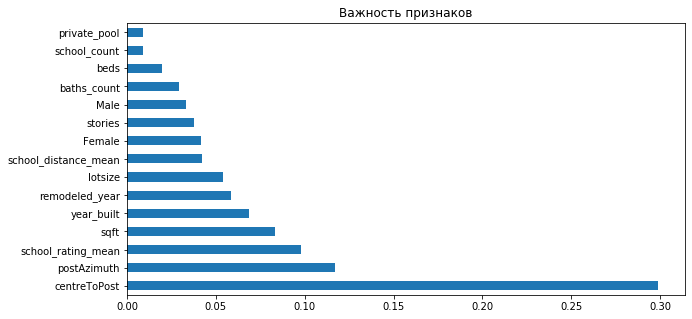

In [97]:
plt.figure()
plt.title("Важность признаков")
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(etr.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [98]:
xgb = XGBRegressor(objective ='reg:gamma', 
                             learning_rate = 0.01,
                             max_depth = 15, 
                             n_estimators = 2000,
                             nthread = -1,
                             eval_metric = 'gamma-nloglik',
                            random_state=42
                             )

xgb.fit(X_train, y_train)

y_predict = xgb.predict(X_test).round(0)
predictions['xgb'] = y_predict
mape = mean_absolute_percentage_error(y_test, y_predict)
medape = median_absolute_percentage_error(y_test, y_predict)
print('MAPE:', mape)
print('MedAPE:', medape)

MAPE: 14.734903129484328
MedAPE: 8.024691358024691


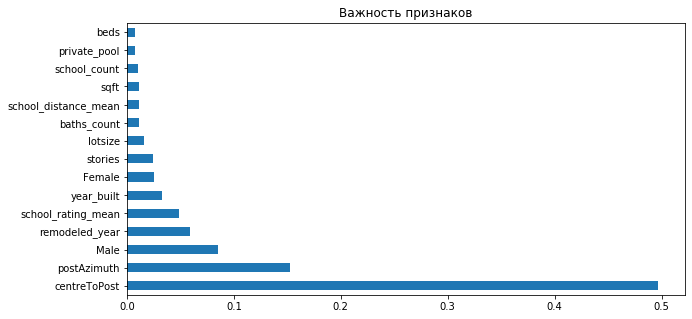

In [99]:
plt.figure()
plt.title("Важность признаков")
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [100]:
catbr = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.15,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          depth=9,
                         )

catbr.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         plot=True)

y_predict = catbr.predict(X_test).round()
predictions['catbr'] = y_predict
mape = mean_absolute_percentage_error(y_test, y_predict)
medape = median_absolute_percentage_error(y_test, y_predict)
print('MAPE:', mape)
print('MedAPE:', medape)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4052838	test: 0.4242936	best: 0.4242936 (0)	total: 30.1ms	remaining: 30.1s
500:	learn: 0.0669162	test: 0.1532246	best: 0.1531224 (486)	total: 8.69s	remaining: 8.66s
999:	learn: 0.0388604	test: 0.1512336	best: 0.1512111 (998)	total: 18.4s	remaining: 0us

bestTest = 0.1512111203
bestIteration = 998

Shrink model to first 999 iterations.
MAPE: 15.122063814137244
MedAPE: 8.695652173913043


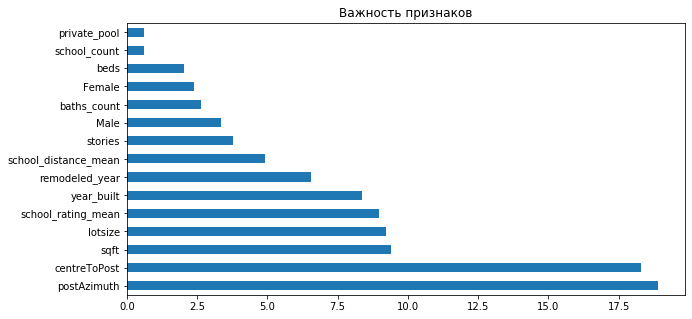

In [101]:
plt.figure()
plt.title("Важность признаков")
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(catbr.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [102]:
predictions.head(10)

,rfr,etr,xgb,catbr
8589,144.0,144.0,144.0,144.0
9611,129.0,130.0,117.0,117.0
12261,114.0,108.0,120.0,109.0
3413,176.0,171.0,174.0,168.0
7878,91.0,93.0,81.0,94.0
10943,120.0,115.0,98.0,96.0
13853,103.0,96.0,98.0,107.0
12994,105.0,97.0,92.0,86.0
5449,82.0,82.0,73.0,80.0
36,194.0,200.0,197.0,192.0


In [103]:
# усредняем значения предсказаний и выводим итоговый результат
predictions['blend'] = round((predictions.sum(axis=1))/len(predictions.columns))
mape = mean_absolute_percentage_error(y_test, predictions['blend'])
medape = median_absolute_percentage_error(y_test, predictions['blend'])
print('MAPE:', mape)
print('MedAPE:', medape)

MAPE: 14.518874977065341
MedAPE: 7.83132530120482


Датасет требует большей подготовки. Получение координат по адресу с бесплатных сервисов требует много времени. Необходимо дополнить новыми данными например: получить параметры дома по Mls_ID, получить дополнительные данные по адресу (перепись, криминальная обстановка, наличие социально значимых мест и тп.).